In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import random
import seaborn as sns
import numpy as np
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
songPopularity = pd.read_csv('./data/song_data.csv')

features = ['song_duration_ms', 
            'acousticness', 'danceability', 
            'energy', 'instrumentalness', 
            'key', 'liveness', 'loudness', 
            'audio_mode', 'speechiness', 
            'tempo', 'time_signature', 'audio_valence']

target = 'song_popularity'

songPopularityFeatures = songPopularity[features]
# # perform min max normalization
# songPopularityFeatures = (songPopularityFeatures - songPopularityFeatures.min()) / (songPopularityFeatures.max() - songPopularityFeatures.min())

songPopularityTarget = songPopularity[target]

<Axes: >

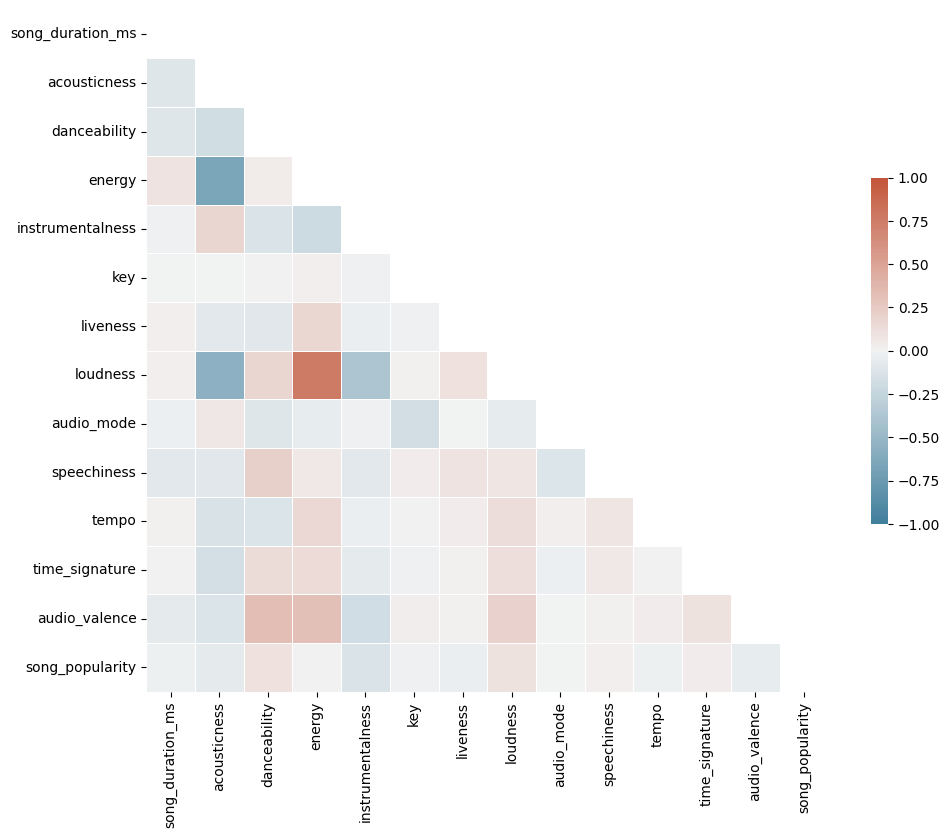

In [3]:
# correlation matrix with triu
corr = songPopularity[features + [target]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [4]:
X_train, X_test, y_train, y_test = train_test_split(songPopularityFeatures, songPopularityTarget, test_size=0.2, random_state=SEED)

In [5]:
def dataframe_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Transform DataFrames into PyTorch tensors using the function
X_train = dataframe_to_tensor(X_train)
X_test = dataframe_to_tensor(X_test)
y_train = dataframe_to_tensor(y_train)
y_test = dataframe_to_tensor(y_test)

In [6]:
import torch.nn as nn


class LinearRegressionModel(nn.Module):
    '''
    Torch Module class.
    Initializes weight randomly and gets trained via train method.
    '''

    def __init__(self, optimizer):
        super().__init__()
        self.optimizer = optimizer

        # Initialize Weights and Bias
        self.weights = nn.Parameter(
            torch.randn(1, 13, dtype=torch.float),
            requires_grad=True)

        self.bias = nn.Parameter(
            torch.randn(1, 13, dtype=torch.float),
            requires_grad=True
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (self.weights * x + self.bias).sum(axis=1)

    def trainModel(
            self,
            epochs: int,
            X_train: torch.Tensor,
            X_test: torch.Tensor,
            y_train: torch.Tensor,
            y_test: torch.Tensor,
            lr: float
    ):
        '''
        Trains linear model using pytorch.
        Evaluates the model against test set for every epoch.
        '''
        # Create empty loss lists to track values
        self.train_loss_values = []
        self.test_loss_values = []

        loss_fn = nn.L1Loss()

        if self.optimizer == 'SGD':
            optimizer = torch.optim.SGD(
                params=self.parameters(),
                lr=lr
            )
        elif self.optimizer == 'Adam':
            optimizer = torch.optim.Adam(
                params=self.parameters(),
                lr=lr
            )

        for epoch in range(epochs):
            self.train()
            y_pred = self(X_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Set the model in evaluation mode
            self.eval()
            with torch.inference_mode():
                self.evaluate(X_test, y_test, epoch, loss_fn, loss)

    def evaluate(self, X_test, y_test, epoch_nb, loss_fn, train_loss):
        '''
        Evaluates current epoch performance on the test set.
        '''
        test_pred = self(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        if epoch_nb % 10 == 0:
            self.train_loss_values.append(train_loss.detach().numpy())
            self.test_loss_values.append(test_loss.detach().numpy())
            print(
                f"Epoch: {epoch_nb} - MAE Train Loss: {train_loss} - MAE Test Loss: {test_loss} ")
            
    def plot_train_test_error(self):
        '''
        Plots the train and test error.
        '''
        plt.figure(figsize=(12, 8))
        plt.plot(self.train_loss_values, label='Train Loss')
        plt.plot(self.test_loss_values, label='Test Loss')
        plt.legend()
        plt.show()

Epoch: 0 - MAE Train Loss: 73599.828125 - MAE Test Loss: 72842.4375 
Epoch: 10 - MAE Train Loss: 71412.984375 - MAE Test Loss: 70671.65625 
Epoch: 20 - MAE Train Loss: 69226.15625 - MAE Test Loss: 68500.890625 
Epoch: 30 - MAE Train Loss: 67039.328125 - MAE Test Loss: 66330.1171875 
Epoch: 40 - MAE Train Loss: 64852.4765625 - MAE Test Loss: 64159.3359375 
Epoch: 50 - MAE Train Loss: 62665.6328125 - MAE Test Loss: 61988.56640625 
Epoch: 60 - MAE Train Loss: 60478.80078125 - MAE Test Loss: 59817.796875 
Epoch: 70 - MAE Train Loss: 58291.95703125 - MAE Test Loss: 57647.01953125 
Epoch: 80 - MAE Train Loss: 56105.11328125 - MAE Test Loss: 55476.25 
Epoch: 90 - MAE Train Loss: 53918.265625 - MAE Test Loss: 53305.46484375 
Epoch: 100 - MAE Train Loss: 51731.3984375 - MAE Test Loss: 51134.65625 
Epoch: 110 - MAE Train Loss: 49544.52734375 - MAE Test Loss: 48963.84765625 


Epoch: 120 - MAE Train Loss: 47357.6484375 - MAE Test Loss: 46793.04296875 
Epoch: 130 - MAE Train Loss: 45170.7734375 - MAE Test Loss: 44622.24609375 
Epoch: 140 - MAE Train Loss: 42983.91015625 - MAE Test Loss: 42451.4375 
Epoch: 150 - MAE Train Loss: 40797.03515625 - MAE Test Loss: 40280.63671875 
Epoch: 160 - MAE Train Loss: 38610.16015625 - MAE Test Loss: 38109.82421875 
Epoch: 170 - MAE Train Loss: 36423.29296875 - MAE Test Loss: 35939.0234375 
Epoch: 180 - MAE Train Loss: 34236.41796875 - MAE Test Loss: 33768.21484375 
Epoch: 190 - MAE Train Loss: 32049.55078125 - MAE Test Loss: 31597.4140625 
Epoch: 200 - MAE Train Loss: 29862.67578125 - MAE Test Loss: 29426.60546875 
Epoch: 210 - MAE Train Loss: 27675.802734375 - MAE Test Loss: 27255.802734375 
Epoch: 220 - MAE Train Loss: 25488.93359375 - MAE Test Loss: 25084.998046875 
Epoch: 230 - MAE Train Loss: 23302.060546875 - MAE Test Loss: 22914.189453125 
Epoch: 240 - MAE Train Loss: 21115.189453125 - MAE Test Loss: 20743.38671875 
E

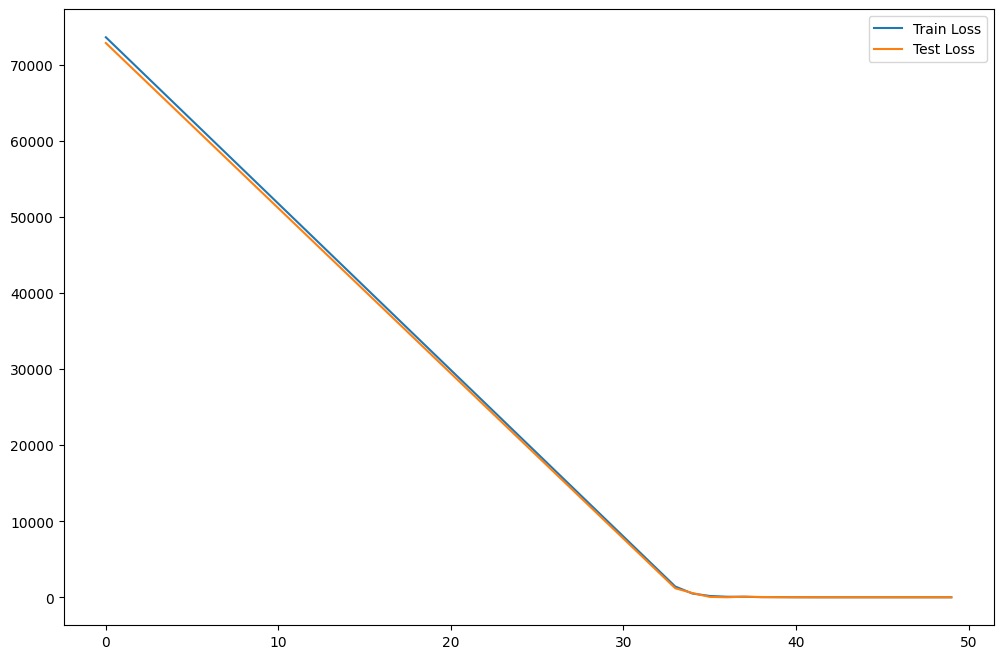

In [7]:
adam_model = LinearRegressionModel('Adam')

adam_model.trainModel(500, X_train, X_test, y_train, y_test, 0.001)
adam_model.plot_train_test_error()

Epoch: 0 - MAE Train Loss: 114191.1171875 - MAE Test Loss: 47291976.0 
Epoch: 10 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 20 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 30 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 40 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 50 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 60 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 70 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 80 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 90 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 100 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 110 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 120 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 47291976.0 
Epoch: 130 - MAE Train Loss: 114192.0546875 - MAE Test Loss: 4

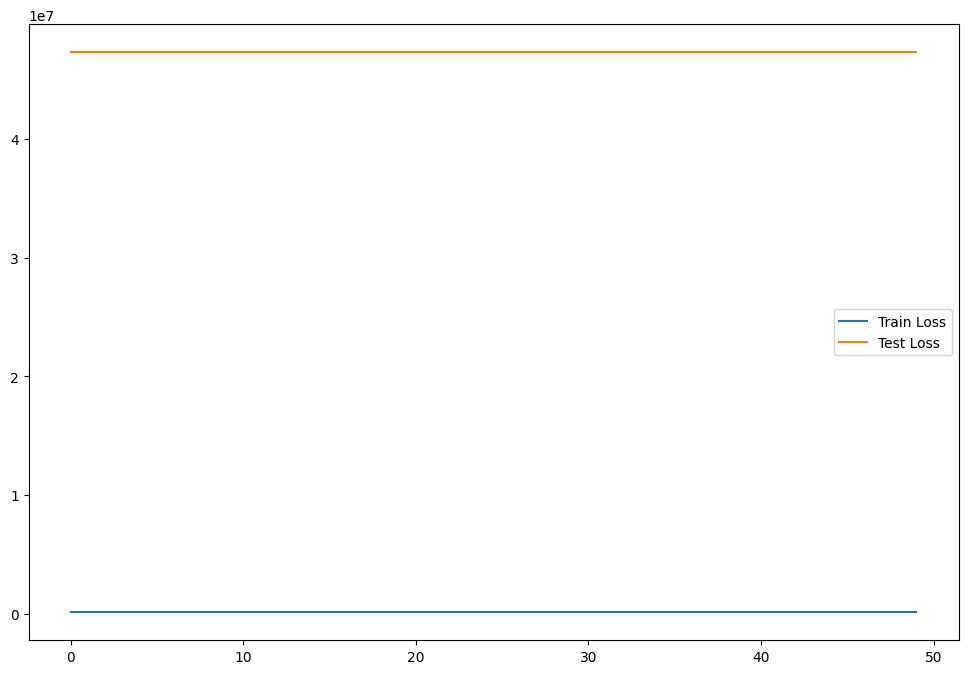

In [8]:
sgd_model = LinearRegressionModel('SGD')
sgd_model.trainModel(500, X_train, X_test, y_train, y_test, 0.001)
sgd_model.plot_train_test_error()